In [15]:
import numpy as np
import pandas as pd
import plotnine as p9; p9.theme_set(p9.theme_bw())
from pandasql import sqldf as sql
import cvxpy as cp
import multiprocessing as mp
from multiprocessing import Pool
import itertools as it
from sklearn.model_selection import StratifiedKFold

In [16]:
mp.cpu_count()

56

In [2]:
!mkdir /home/jupyter/mosek
!cp mosek.lic /home/jupyter/mosek/mosek.lic
# !cat /home/jupyter/mosek/mosek.lic

mkdir: cannot create directory ‘/home/jupyter/mosek’: File exists
cp: cannot create regular file '/home/jupyter/mosek/mosek.lic': Permission denied


In [3]:
print(cp.installed_solvers())

['ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


### Data

Have vectors of observations $Y_i \in \Re^{d}$

### "Pseudo-Logistic" Objective

$$\max \Biggr[\sum_{contact_i=1} Y_i\beta - \sum_{contact_i=0} Y_i \beta \Biggr] - \gamma \Biggr[ \sum_{contact_i=1} \log(1+e^{Y_i\beta}) - \sum_{contact_i=0} \log(1+e^{-Y_i\beta}) \Biggr]$$

$$||\beta||_2 = 1$$

Tunable with $\gamma$:
* Linear (Difference in Means) if $\gamma=0$
* Logistic if $\gamma=1$
* "Sub-logistic" if $0 < \gamma < 1$ 
* "Super-logistic" if $\gamma > 1$ 



### Simulations

Steps:
1. Sample large observational dataset
2. Sample small experimental dataset
3. Estimate beta in a few different ways:
  1. Estimate beta with linear and logistic fn on obs data
  2. Estimate beta with linear and logistic fn on exp data (cross-fit)
4. Estimate alpha and SE(alpha) in the experimental dataset with the following betas:
  1. All those estimated in Step #3
  2. "Null" beta (mean of all Y dimensions)
  3. "Oracle" beta (true beta)

Simulation Parameters:
* N obs in experimental dataset
* N obs in observational dataset / N obs in experimental dataset
* N dimensions in outcome [higher number -> more sparsity, since I will just set beta=1 in the first dimension for now and beta=0 in all the others]
* Alpha (treatement effect in dims with beta==1)
* SD in affected dimensions / Alpha [higher value makes it harder to est beta]
* SD in unaffected dimensions / SD in affected dimensions [higher value makes logistic objective outperform linear objective]

In [4]:
def dgp2(s, n, alpha, sd_a, sd_u, n_dims):
  
    np.random.seed(s)

    # Make beta==1 in just the first dim
    true_beta = np.concatenate((np.array([1]), np.repeat(0, n_dims-1)))

    # Define SD
    sd_y = np.concatenate((np.array([sd_a*alpha]), np.repeat(sd_u*sd_a*alpha, n_dims-1)))

    # Sample errors and contacts
    epsilons = np.random.normal(scale=np.tile(sd_y, (n,1)), size=(n,n_dims))
    contact = np.random.binomial(1, 0.5, size=n)
    

    e_y = np.outer(np.expand_dims(contact,1), true_beta) * alpha
    y = e_y + epsilons

    return((
      e_y,
      y,
      contact,
      true_beta
    ))


# Verify alpha is as expected using true beta to estimate
N_SIMS = 20
N_DIMS = [3, 5, 10]
est_alphas = []
for ndims in N_DIMS:
    for s in range(N_SIMS):
        _, y, c, true_beta = dgp2(s, 100, 2, 2, 2, ndims)
        y_trans = y @ true_beta
        est_alpha = np.mean(y_trans[c==1]) - np.mean(y_trans[c==0])
        est_alphas.append((ndims, 'true beta', est_alpha))

        # also estimate with uniform beta
        est_alpha_null = np.mean(y[c==1]) - np.mean(y[c==0])
        est_alphas.append((ndims, 'uniform null beta', est_alpha_null))

est_alphas_df = pd.DataFrame(est_alphas, columns=['n_dims', 'type', 'est_alpha'])
(p9.ggplot(est_alphas_df, p9.aes(x='n_dims', y='est_alpha', color='type')) + 
      p9.stat_summary(fun_data='mean_sdl', fun_args={'mult':1.96}, geom='pointrange', position=p9.positions.position_dodge(30)) +
      p9.stat_summary(fun_data='mean_se', geom='line') +
      p9.xlab("N dimensions in oucome") + p9.ylab("Est alphas") + p9.ylim(0,None) +
      p9.geom_hline(yintercept=2, linetype="dashed")
)

est_alphas_df.groupby(['n_dims','type'])[['est_alpha']].agg(['mean', 'std'])

est_alpha          
                              mean       std
n_dims type                                 
3      true beta          1.972995  0.678661
       uniform null beta  0.653447  1.142983
5      true beta          1.973999  0.742207
       uniform null beta  0.131068  0.628202
10     true beta          1.929119  0.643140
       uniform null beta  0.186032  0.430283

In [5]:
# Pseudo-Logistic w fused lasso
def get_pseudo_logistic_coefs_w_penalties(y, c, g):
  
    n_dims = y.shape[1]
    Y_contact = np.expand_dims(c,1) * y
    Y_no_contact = np.expand_dims(1-c,1) * y

    beta = cp.Variable(shape=n_dims, nonneg=True)
    obj = cp.sum((Y_contact @ beta) - (Y_no_contact @ beta))
    obj -= g*cp.sum(cp.logistic(Y_contact @ beta) + cp.logistic(-1*Y_no_contact @ beta))

    prob = cp.Problem(
      cp.Maximize(obj),
      [cp.norm(beta, p=2) <= 1]
    )

    prob.solve(solver=cp.MOSEK)

    # normalize so L2 norm equal to 1
    est_beta = beta.value / np.linalg.norm(beta.value, 2)
    return(est_beta)

# Test
_, y, c, true_beta = dgp2(s, 100, 2, 2, 2, 3)
get_pseudo_logistic_coefs_w_penalties(y, c, 1)

array([9.98526997e-01, 2.50260012e-05, 5.42571166e-02])

In [6]:
# Function to estimate beta and Y_beta with cross-fitting
def cross_fit_beta_est_and_est_y_beta(k_folds, y, c, g):
    kf = StratifiedKFold(n_splits=k_folds)
    n_dims = y.shape[1]
    est_betas = [np.zeros(n_dims)] * y.shape[0]
    Y_betas = np.zeros(y.shape[0])
    for i, (train_index, test_index) in enumerate(kf.split(y, c)):
        est_b_for_fold = get_pseudo_logistic_coefs_w_penalties(y[train_index], c[train_index], g)
        Y_betas[test_index] = y[test_index] @ est_b_for_fold
    return(Y_betas)

# Test
_, y, c, true_beta = dgp2(s, 50, 2, 2, 1, 3)
cross_fit_beta_est_and_est_y_beta(10, y, c, 1)

array([-1.51341880e+00, -2.60486546e+00,  3.45527773e+00, -4.53034192e+00,
       -1.76079779e+00, -2.26442787e+00,  2.22655052e+00,  7.92232021e+00,
       -8.52375726e-01, -2.20957739e-01,  9.54978575e+00, -1.17675434e+00,
        3.85286276e+00,  4.03634495e+00, -1.94066117e-01,  7.41857595e-01,
        2.86456195e+00, -1.08911413e+00, -2.00178536e+00, -1.44164014e-01,
       -9.66696797e-01,  6.43647593e+00, -7.61965258e-01, -5.15674124e+00,
        4.81359846e+00, -2.72441757e+00, -6.06047327e+00,  4.93598321e+00,
        1.25089005e+00, -6.85498630e+00,  8.14680736e-01,  2.54591762e+00,
       -2.03362719e-01, -6.30866614e+00, -4.92591887e+00,  2.34532307e+00,
       -6.14518219e+00,  1.10914304e+00,  7.84855656e+00, -2.83580056e+00,
       -1.82309740e+00, -5.93774534e+00,  6.04821214e+00,  4.86069819e+00,
        2.88390685e+00,  2.05252778e-03, -5.53317091e-02,  8.42694818e-01,
        2.97579177e+00, -9.84130533e-01])

In [7]:
# Function to generate alphas and its SE
def est_alpha(ndims, y_betas, c):
    est = (np.mean(y_betas[c==1]) - np.mean(y_betas[c==0]))/ndims
    se = np.sqrt(np.var(y_betas[c==1]/ndims)/np.sum(c==1) + np.var(y_betas[c==0]/ndims)/np.sum(c==0))
    return((est, se))

# Test
_, y, c, true_beta = dgp2(s, 1000, 2, 1, 1, 3)
est_alpha(3, cross_fit_beta_est_and_est_y_beta(10, y, c, 0), c)

(0.6715513534764107, 0.043333492118597376)

In [8]:
# Function generate alphas using all the different betas we want to compare
def gen_alphas_w_different_betas(
    seed,
    k_folds,
    exp_sample_size,
    rel_obs_sample_size,
    alpha,
    sd_a, 
    sd_u,
    n_dims
):

    ##########################################################
    # Gen obs and exp data
    ##########################################################
    _, y_obs, c_obs, _ = dgp2(seed, exp_sample_size*rel_obs_sample_size, alpha, sd_a, sd_u, n_dims)
    _, y_exp, c_exp, true_beta = dgp2(seed*2, exp_sample_size, alpha, sd_a, sd_u, n_dims)


    ##########################################################
    # Gen alpha w oracle and null betas
    ##########################################################
    oracle_alpha, oracle_alpha_se = est_alpha(n_dims, y_exp @ true_beta, c_exp)
    null_beta = np.repeat(1/n_dims, n_dims)
    null_alpha, null_alpha_se = est_alpha(n_dims, y_exp @ null_beta, c_exp)

    # Generate output DF for oracle and null betas
    oracle_null_df = pd.DataFrame({
      'seed': np.repeat(seed, 2),
      'method': ['oracle', 'null'],
      'est_alpha': [oracle_alpha, null_alpha],
      'est_alpha_se': [oracle_alpha_se, null_alpha_se]
    })

    ##########################################################
    # Estimate alphas using betas fit on observational data
    ##########################################################
    obs_beta_linear = get_pseudo_logistic_coefs_w_penalties(y_obs, c_obs, 0,)
    obs_beta_logistic = get_pseudo_logistic_coefs_w_penalties(y_obs, c_obs, 1)
    obs_beta_linear_alpha, obs_beta_linear_alpha_se = est_alpha(n_dims, y_exp @ obs_beta_linear, c_exp)
    obs_beta_logistic_alpha, obs_beta_logistic_alpha_se = est_alpha(n_dims, y_exp @ obs_beta_logistic, c_exp)

    # Generate output DF for observational data betas
    obs_df = pd.DataFrame({
      'seed': np.repeat(seed, 2),
      'method': ['obs beta (linear)', 'obs beta (logistic)'],
      'est_alpha': [obs_beta_linear_alpha, obs_beta_logistic_alpha],
      'est_alpha_se': [obs_beta_linear_alpha_se, obs_beta_logistic_alpha_se]
    })

    ##########################################################
    # Estimate alphas using betas cross-fit on experimental data
    ##########################################################
    exp_linear_cf_y_beta = cross_fit_beta_est_and_est_y_beta(k_folds, y_exp, c_exp, 0)
    exp_logistic_cf_y_beta = cross_fit_beta_est_and_est_y_beta(k_folds, y_exp, c_exp, 1)
    exp_beta_linear_alpha, exp_beta_linear_alpha_se = est_alpha(n_dims, exp_linear_cf_y_beta, c_exp)
    exp_beta_logistic_alpha, exp_beta_logistic_alpha_se = est_alpha(n_dims, exp_logistic_cf_y_beta, c_exp)

    # Generate output DF for experimental data betas
    exp_df = pd.DataFrame({
      'seed': np.repeat(seed, 2),
      'method': ['exp beta (linear)', 'exp beta (logistic)'],
      'est_alpha': [exp_beta_linear_alpha, exp_beta_logistic_alpha],
      'est_alpha_se': [exp_beta_linear_alpha_se, exp_beta_logistic_alpha_se]
    })

    return(pd.concat([oracle_null_df, obs_df, exp_df]))


# Test
gen_alphas_w_different_betas(1, 10, 100, 10, 1, 4, 2, 3)

,seed,method,est_alpha,est_alpha_se
0,1,oracle,0.895209,0.284878
1,1,null,0.940945,0.266322
0,1,obs beta (linear),1.159338,0.291576
1,1,obs beta (logistic),0.989161,0.281007
0,1,exp beta (linear),1.418425,0.473045
1,1,exp beta (logistic),1.229368,0.333368


In [9]:
# Create tuples of parameters to run in parallel
N_SIMS = 500
K_FOLDS = 10
EXP_SAMPLE_SIZE = 100
ALPHA = 1

N_DIMS = [3, 5, 10]
REL_OBS_SAMPLE_SIZES = [10]
SD_A = [2]
SD_U = [1, 2, 4, 6, 8, 10]

param_grid = it.product(
    range(N_SIMS),
    REL_OBS_SAMPLE_SIZES,
    SD_A,
    SD_U,
    N_DIMS
)

# Fun to run sims given params and return dataframe
def run_sim(params):
    s, rel_obs_sample_size, sd_a, sd_u, n_dims = params
    df = gen_alphas_w_different_betas(s, K_FOLDS, EXP_SAMPLE_SIZE, rel_obs_sample_size, ALPHA, sd_a, sd_u, n_dims)
    df['exp_sample_size'] = EXP_SAMPLE_SIZE
    df['rel_obs_sample_size'] = rel_obs_sample_size
    df['alpha'] = ALPHA
    df['sd_a'] = sd_a
    df['sd_u'] = sd_u
    df['n_dims'] = n_dims
    return(df)

# Test
run_sim((1, 10, 4, 4, 3))

,seed,method,est_alpha,est_alpha_se,exp_sample_size,rel_obs_sample_size,alpha,sd_a,sd_u,n_dims
0,1,oracle,0.895209,0.284878,100,10,1,4,4,3
1,1,null,1.583486,0.508175,100,10,1,4,4,3
0,1,obs beta (linear),1.857432,0.548644,100,10,1,4,4,3
1,1,obs beta (logistic),0.992107,0.281844,100,10,1,4,4,3
0,1,exp beta (linear),2.439467,1.024382,100,10,1,4,4,3
1,1,exp beta (logistic),1.307787,0.354399,100,10,1,4,4,3


In [ ]:
# Run sims for each params in parallel
with Pool() as pool:
    results = pool.map(run_sim, param_grid, chunksize=4)

In [11]:
results_df = pd.concat(results)

# Est z scores
results_df['z'] = results_df['est_alpha']/results_df['est_alpha_se']
results_df['stat_sig'] = np.where(results_df['z']>1.96,1,0)

# Power by method
agg_results = results_df.groupby(['exp_sample_size','rel_obs_sample_size','alpha','sd_a','sd_u','n_dims','method'])[['est_alpha','est_alpha_se','stat_sig']].mean().reset_index()

# Add conf interval
agg_results['se'] = np.sqrt(agg_results['stat_sig']*(1-agg_results['stat_sig'])/N_SIMS)
agg_results['lb'] = agg_results['stat_sig'] - 1.96*agg_results['se']
agg_results['ub'] = agg_results['stat_sig'] + 1.96*agg_results['se']

agg_results.head()

,exp_sample_size,rel_obs_sample_size,alpha,sd_a,sd_u,n_dims,method,est_alpha,est_alpha_se,stat_sig,se,lb,ub
0,100,10,1,2,1,3,exp beta (linear),0.309890,0.132159,0.618,0.021729,0.575411,0.660589
1,100,10,1,2,1,3,exp beta (logistic),0.303525,0.132207,0.614,0.021772,0.571327,0.656673
2,100,10,1,2,1,3,null,0.114929,0.076240,0.328,0.020996,0.286848,0.369152
3,100,10,1,2,1,3,obs beta (linear),0.336608,0.132442,0.718,0.020123,0.678558,0.757442
4,100,10,1,2,1,3,obs beta (logistic),0.336228,0.132430,0.722,0.020036,0.682730,0.761270


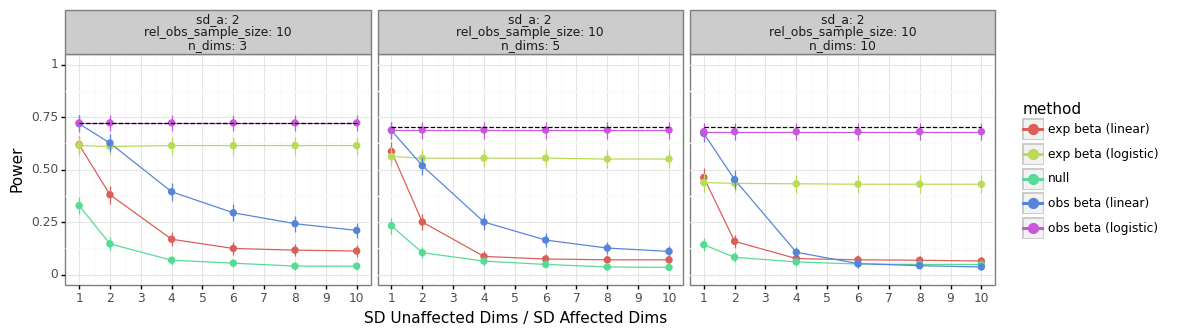

<ggplot: (8779798680849)>

In [12]:
(
    p9.ggplot(agg_results.query('method != "oracle"'), p9.aes(x='sd_u', y='stat_sig', ymin='lb', ymax='ub', color='method')) + 
    p9.facet_wrap('~sd_a+rel_obs_sample_size+n_dims', labeller='label_both') + p9.geom_line() + p9.geom_pointrange() +
    p9.coord_cartesian(xlim=(1,10)) + p9.theme(figure_size=(12, 3)) +
    p9.scale_x_continuous(labels=range(11), breaks=range(11), name="SD Unaffected Dims / SD Affected Dims") +
    p9.scale_y_continuous(limits=(0,1), name="Power") + 
    p9.geom_line(data=agg_results.query('method == "oracle"'), color="black", linetype="dashed")
)

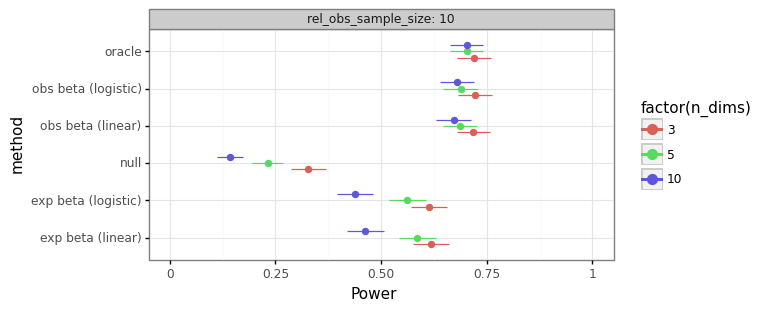

<ggplot: (8779793606705)>

In [13]:
# Just equal SD results
(
    p9.ggplot(agg_results.query('sd_u==1'), p9.aes(x='method', y='stat_sig', ymin='lb', ymax='ub', color='factor(n_dims)')) + 
    p9.facet_wrap('~rel_obs_sample_size', labeller='label_both') + p9.geom_pointrange(position=p9.position_dodge(0.5)) +
    p9.theme(figure_size=(6, 3)) +
    p9.scale_y_continuous(limits=(0,1), name="Power") +
    p9.coord_flip()
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_summary : Removed 17 rows containing non-finite values.


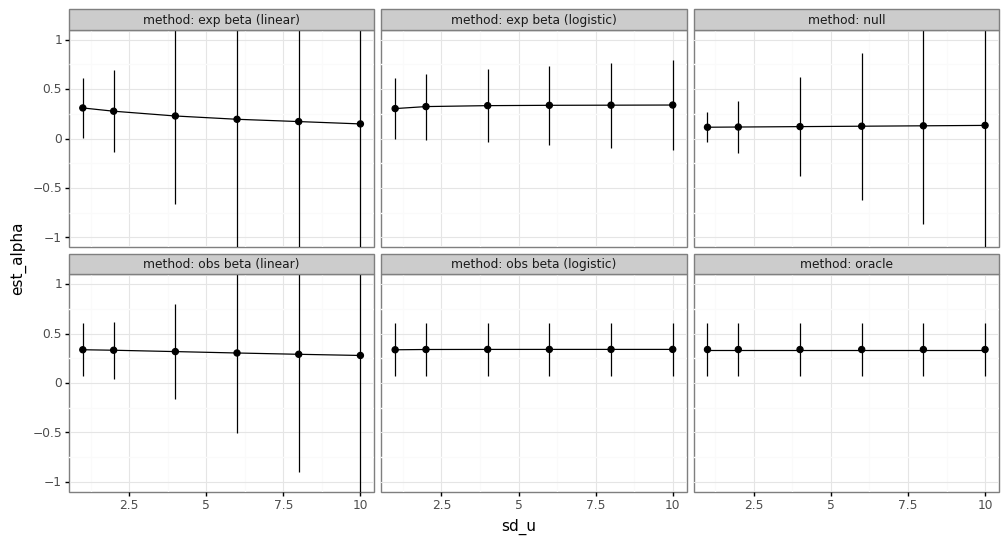

<ggplot: (8779793433405)>

In [14]:
(
    p9.ggplot(results_df.query("n_dims == 3"), p9.aes(x='sd_u', y='est_alpha')) + 
    p9.facet_wrap('~method', labeller='label_both') +
    p9.coord_cartesian(xlim=(1,10), ylim=(-1,1)) + p9.theme(figure_size=(12, 6)) +
    # p9.scale_x_continuous(labels=range(11), breaks=range(11), name="SD Unaffected Dims / SD Affected Dims") +
    # p9.scale_y_continuous(limits=(0,2), name="Est Alpha") + 
    p9.stat_summary(fun_data='mean_sdl', fun_args={'mult':1.96}, geom='pointrange', position=p9.position_dodge(0.5)) + p9.stat_summary(fun_data='mean_sdl', geom='line')
)

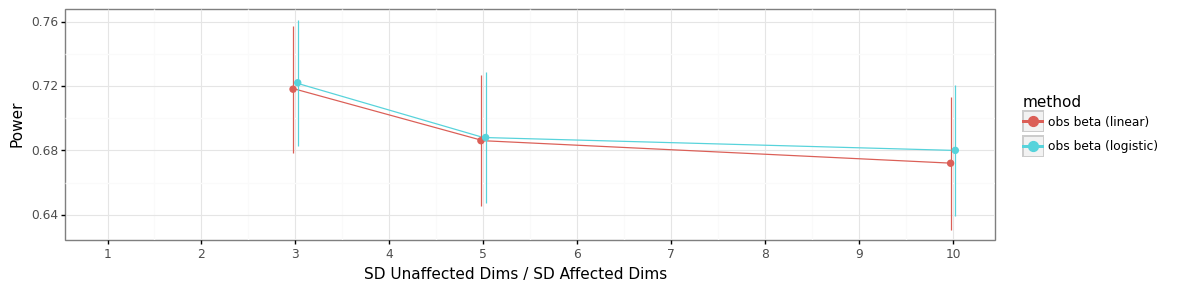

<ggplot: (8779787910717)>

In [15]:
# Compare just the sd_u==1 and obs linear vs obs logistic methods

(
    p9.ggplot(agg_results[agg_results.method.str.contains('obs') & (agg_results.sd_u==1)], p9.aes(x='n_dims', y='stat_sig', ymin='lb', ymax='ub', color='method')) + 
    p9.geom_line() + p9.geom_pointrange(position=p9.position_dodge(0.1)) +
    p9.coord_cartesian(xlim=(1,10)) + p9.theme(figure_size=(12, 3)) +
    p9.scale_x_continuous(labels=range(11), breaks=range(11), name="SD Unaffected Dims / SD Affected Dims") +
    p9.scale_y_continuous(name="Power")
)

## Run a larger set of simulations just for obs methods

In [11]:
# Function generate alphas using all the different betas we want to compare
def gen_alphas_w_different_betas_obs_only(
    seed,
    exp_sample_size,
    rel_obs_sample_size,
    alpha,
    sd_a, 
    sd_u,
    n_dims
):

    ##########################################################
    # Gen obs and exp data
    ##########################################################
    _, y_obs, c_obs, _ = dgp2(seed, exp_sample_size*rel_obs_sample_size, alpha, sd_a, sd_u, n_dims)
    _, y_exp, c_exp, true_beta = dgp2(seed*2, exp_sample_size, alpha, sd_a, sd_u, n_dims)


    ##########################################################
    # Estimate alphas using betas fit on observational data
    ##########################################################
    obs_beta_linear = get_pseudo_logistic_coefs_w_penalties(y_obs, c_obs, 0,)
    obs_beta_logistic = get_pseudo_logistic_coefs_w_penalties(y_obs, c_obs, 1)
    obs_beta_linear_alpha, obs_beta_linear_alpha_se = est_alpha(n_dims, y_exp @ obs_beta_linear, c_exp)
    obs_beta_logistic_alpha, obs_beta_logistic_alpha_se = est_alpha(n_dims, y_exp @ obs_beta_logistic, c_exp)

    # Generate output DF for observational data betas
    obs_df = pd.DataFrame({
      'seed': np.repeat(seed, 2),
      'method': ['obs beta (linear)', 'obs beta (logistic)'],
      'est_alpha': [obs_beta_linear_alpha, obs_beta_logistic_alpha],
      'est_alpha_se': [obs_beta_linear_alpha_se, obs_beta_logistic_alpha_se]
    })

    return(obs_df)


# Test
gen_alphas_w_different_betas_obs_only(1, 100, 10, 1, 4, 2, 3)

,seed,method,est_alpha,est_alpha_se
0,1,obs beta (linear),1.159338,0.291576
1,1,obs beta (logistic),0.989161,0.281007


In [ ]:
N_SIMS = 500
EXP_SAMPLE_SIZE = 100
ALPHA = 1

N_DIMS = [10]
REL_OBS_SAMPLE_SIZES = [10]
SD_A = [2]
SD_U = [1]

param_grid = it.product(
    range(N_SIMS),
    REL_OBS_SAMPLE_SIZES,
    SD_A,
    SD_U,
    N_DIMS
)

# Fun to run sims given params and return dataframe
def run_sim_obs_only(params):
    s, rel_obs_sample_size, sd_a, sd_u, n_dims = params
    df = gen_alphas_w_different_betas_obs_only(s, EXP_SAMPLE_SIZE, rel_obs_sample_size, ALPHA, sd_a, sd_u, n_dims)
    df['exp_sample_size'] = EXP_SAMPLE_SIZE
    df['rel_obs_sample_size'] = rel_obs_sample_size
    df['alpha'] = ALPHA
    df['sd_a'] = sd_a
    df['sd_u'] = sd_u
    df['n_dims'] = n_dims
    return(df)

# Test
# run_sim_obs_only((1, 10, 4, 4, 3))

# Run sims for each params in parallel
with Pool() as pool:
    results_obs_only = pool.map(run_sim_obs_only, param_grid, chunksize=4)
        
results_obs_only_df = pd.concat(results_obs_only)

# Est z scores
results_obs_only_df['z'] = results_obs_only_df['est_alpha']/results_obs_only_df['est_alpha_se']
results_obs_only_df['stat_sig'] = np.where(results_obs_only_df['z']>1.96,1,0)

# Power by method
agg_results_obs_only = results_obs_only_df.groupby(['exp_sample_size','rel_obs_sample_size','alpha','sd_a','sd_u','n_dims','method'])[['est_alpha','est_alpha_se','stat_sig']].mean().reset_index()

# Add conf interval
agg_results_obs_only['se'] = np.sqrt(agg_results_obs_only['stat_sig']*(1-agg_results_obs_only['stat_sig'])/N_SIMS)
agg_results_obs_only['lb'] = agg_results_obs_only['stat_sig'] - 1.96*agg_results_obs_only['se']
agg_results_obs_only['ub'] = agg_results_obs_only['stat_sig'] + 1.96*agg_results_obs_only['se']

# Compare just the sd_u==1 and obs linear vs obs logistic methods

(
    p9.ggplot(agg_results_obs_only, p9.aes(x='n_dims', y='stat_sig', ymin='lb', ymax='ub', color='method')) + 
    p9.geom_line() + p9.geom_pointrange(position=p9.position_dodge(0.1)) +
    p9.coord_cartesian(xlim=(1,20)) + p9.theme(figure_size=(12, 3)) +
    p9.scale_x_continuous(labels=range(21), breaks=range(21), name="N Dims") +
    p9.scale_y_continuous(name="Power")
)